### Summary Results

Average norm = 67.352  
Standard deviation of the norms = 9.354

#### Histogram of norms over samples & tokens.

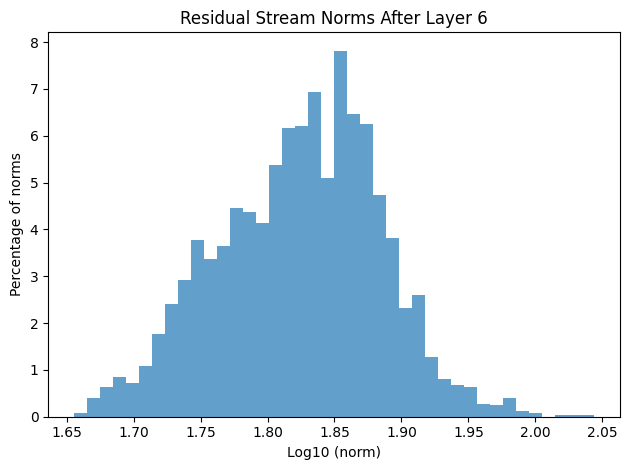

### Code to reproduce the results

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['HF_HOME'] = "/data/assets/huggingface/"

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

#* pip install git+https://github.com/TransformerLensOrg/TransformerLens
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer

In [3]:
torch.set_grad_enabled(False)

device = utils.get_device()
print("Device: ", device)

Device:  cuda


In [4]:
model = HookedTransformer.from_pretrained("gpt2-small", device=device)
model.eval()
print("Loaded the GPT2 Small Model!")

Loaded pretrained model gpt2-small into HookedTransformer
Loaded the GPT2 Small Model!


In [5]:
dataset = load_dataset("NeelNanda/pile-10k", split="train")
print(dataset)
print(dataset[0]['text'][:100])

Dataset({
    features: ['text', 'meta'],
    num_rows: 10000
})
It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playi


In [6]:
dataset = dataset.select(range(100))
print(len(dataset))

100


Measure the average norm of activation vectors **after layer 6 in the residual stream** of GPT-2 small (after subtracting mean activation), and how

In [7]:
act_name = utils.get_act_name(name="resid_post", layer=6)
print(act_name)

blocks.6.hook_resid_post


In [8]:
for example in dataset:
    print(example['text'][:100])
    break

It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playi


In [9]:
all_activations = [] #* store all the activations in this so we can subtract the mean activation

for example in dataset:
    prompt = example['text'][:100]

    cache = model.run_with_cache(model.to_tokens(prompt))[1] # now calculate the magnitude of the activations
    activation = cache[act_name][0]

    all_activations.append( activation[1:, :].cpu().numpy() )

    # for i in range(1, activation.shape[0]):
    #     all_activations.append( activation[i] )

    # l2_norm = torch.linalg.norm(activation[0], dim=-1).cpu()
    # l2_norm = l2_norm[1:] #* ignore the bos sequence due to the outlier values
    # all_norms.extend( l2_norm.numpy() )

In [13]:
stacked_activations = np.vstack( all_activations )
print(stacked_activations.shape)

(2570, 768)


subtract the mean activation from the activations

In [14]:
normalized_activations = stacked_activations - np.mean(stacked_activations, axis=0)

calculate the norm

In [21]:
all_norms = np.linalg.norm(normalized_activations, axis=-1)

In [22]:
print(f"Mean: {np.mean(all_norms):.3f}")
print(f"Std: {np.std(all_norms):.3f}")

Mean: 67.352
Std: 9.354


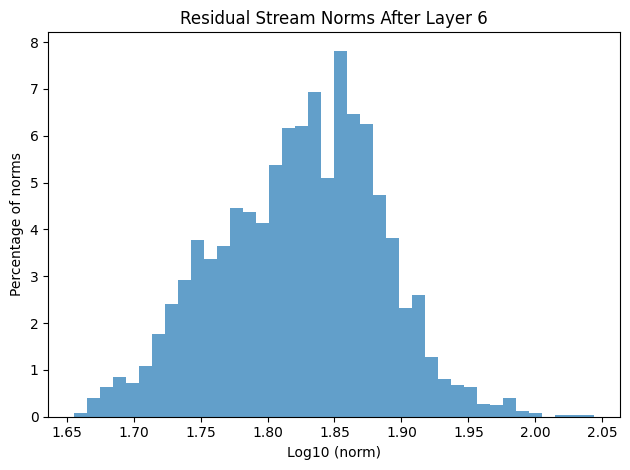

In [24]:
plt.hist(np.log10(all_norms), bins=40, density=True, alpha=0.7)

plt.ylabel('Percentage of norms')
plt.xlabel('Log10 (norm)')
plt.title('Residual Stream Norms After Layer 6')

plt.savefig("gpt2-small-residual-norm-post-layer6.png")

plt.tight_layout()
plt.show()